# Exploratory Data Analysis for Sentiment Dataset
This notebook provides a structured and thorough EDA across three platforms: **Twitter**, **Reddit**, and **Bitcointalk**. We explore the raw and engineered features through statistical and visual analysis.

In [1]:
#Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import math
import statsmodels.api as sm
import scipy.stats as stats


In [ ]:
# Load dataset
df = pd.read_csv("Data/baseline_data_v1.csv")

# Show a preview
df.head()


,date,twitter_fomo,twitter_uncertain,twitter_hopeful,twitter_bearish,twitter_pessimistic_doubtful,twitter_sad,twitter_fearful_concerned,twitter_angry,twitter_mistrustful,...,open,high,low,close_binance,volume,quote_asset_volume,num_trades,taker_buy_base_volume,taker_buy_quote_volume,close_augmento
0,2017-08-31 23:00:00,-0.44576,-0.942589,0.019913,-0.256830,-0.453646,-0.219225,0.197802,-0.395022,-0.183469,...,4699.00,4724.89,4683.36,4724.89,12.001618,56396.880782,162.0,9.227133,43376.763033,4734.26
1,2017-09-01 00:00:00,-0.44576,0.196526,0.204217,-0.526668,-0.453646,-0.219225,1.312522,2.287562,-0.183469,...,4689.89,4745.35,4689.89,4721.05,15.711673,74145.736108,105.0,2.494201,11801.623970,4763.99
2,2017-09-01 01:00:00,-0.44576,0.174289,-0.007331,0.075580,0.341731,-0.219225,0.167287,-0.395022,-0.183469,...,4730.05,4766.99,4701.11,4725.00,28.111344,133018.250682,270.0,9.947925,47251.438702,4771.30
3,2017-09-01 02:00:00,-0.44576,0.196526,1.015152,-1.021372,0.622453,-0.219225,-0.504058,0.946270,-0.183469,...,4740.99,4767.00,4723.00,4735.96,15.140693,71825.621786,147.0,9.184023,43593.354559,4764.00
4,2017-09-01 03:00:00,-0.44576,-0.468345,0.771871,-1.021372,-0.453646,-0.219225,-0.504058,-0.395022,-0.183469,...,4767.00,4767.00,4713.67,4714.73,16.684268,78802.109354,101.0,1.914899,9118.754582,4745.60


In [1]:
# =========================
# UTILITY SECTION
# =========================

import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import re
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from factor_analyzer import FactorAnalyzer, calculate_kmo
from datetime import datetime, timedelta
import random

# ---- ANSI Color Codes for terminal formatting ----
class ColorCodes:
    """Class for terminal color codes used in logging."""
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    RED = '\033[31m'
    GREEN = '\033[32m'
    YELLOW = '\033[33m'
    BLUE = '\033[34m'
    MAGENTA = '\033[35m'
    CYAN = '\033[36m'
    WHITE = '\033[37m'
    BLACK = '\033[30m'

# ---- Custom formatter to strip ANSI color codes for file logging ----
class StripColorFormatter(logging.Formatter):
    """Custom log formatter to remove ANSI codes from log file output."""
    ansi_escape = re.compile(r'(?:\x1B[@-_][0-?]*[ -/]*[@-~])')

    def format(self, record):
        message = super().format(record)
        return self.ansi_escape.sub('', message)

# ---- Logger Initialization ----
def reinitialize_logger(name="DualLogger", log_file="eda_output.log", level=logging.INFO):
    """
    Initializes and configures a logger that outputs to both the terminal (with colors)
    and a log file (without ANSI codes).
    """
    logger = logging.getLogger(name)
    logger.setLevel(level)

    if logger.hasHandlers():
        logger.handlers.clear()

    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(level)
    console_handler.setFormatter(logging.Formatter('%(message)s'))

    file_handler = logging.FileHandler(log_file, mode='w')
    file_handler.setLevel(level)
    file_handler.setFormatter(StripColorFormatter('%(message)s'))

    logger.addHandler(console_handler)
    logger.addHandler(file_handler)

    return logger

# ---- Initialize Logger ----
log = reinitialize_logger()


# =========================
# SYNTHETIC DATA GENERATOR SECTION
# =========================

class SyntheticDataGenerator:
    """Generates synthetic datasets for testing data wrangling pipelines."""

    @staticmethod
    def generate(rows=100):
        """
        Generate a synthetic dataset with:
        - floating point values
        - integer values
        - datetime values
        - text and long text
        - messy currency formats
        - dates as strings
        - floats as strings
        - strings with NaN values
        """
        base_date = datetime.now()

        text_with_nan = [random.choice(['cat', 'dog', 'elephant', None, np.nan]) for _ in range(rows)]

        data = {
            "float_column": np.random.uniform(0, 1000, size=rows),
            "integer_column": np.random.randint(0, 1000, size=rows),
            "datetime_column": [base_date - timedelta(days=i) for i in range(rows)],
            "text_column": [random.choice(['apple', 'banana', 'cherry', '42']) for _ in range(rows)],
            "long_text_column": ["Lorem ipsum dolor sit amet, consectetur adipiscing elit. " * random.randint(1, 3) for _ in range(rows)],
            "currency_messy": random.choices([
                "$1,000.00", "$100.5", "$1.50", "$1,234.56", "€1.000,00", "£2,500.99", 
                "1.000,00€", "$ 1,000.00", "1000.00", "1.000,00€", "12,50€"], k=rows),
            "date_string": [(base_date - timedelta(days=i)).strftime('%d-%m-%Y') for i in range(rows)],
            "float_as_string": [f"{np.round(np.random.uniform(0, 100), 2)}" for _ in range(rows)],
            "string_with_nan": text_with_nan
        }

        return pd.DataFrame(data)

# Example usage:
df_synthetic = SyntheticDataGenerator.generate(100)
print(df_synthetic.head())


   float_column  integer_column            datetime_column text_column  \
0    645.744751             912 2025-04-10 15:48:07.104063      banana   
1    995.337427             184 2025-04-09 15:48:07.104063      banana   
2    267.015096             739 2025-04-08 15:48:07.104063          42   
3    695.626613             648 2025-04-07 15:48:07.104063      banana   
4    371.107873             742 2025-04-06 15:48:07.104063      banana   

                                    long_text_column currency_messy  \
0  Lorem ipsum dolor sit amet, consectetur adipis...      £2,500.99   
1  Lorem ipsum dolor sit amet, consectetur adipis...      $1,234.56   
2  Lorem ipsum dolor sit amet, consectetur adipis...      1.000,00€   
3  Lorem ipsum dolor sit amet, consectetur adipis...      $1,234.56   
4  Lorem ipsum dolor sit amet, consectetur adipis...      $1,000.00   

  date_string float_as_string string_with_nan  
0  10-04-2025           76.49             NaN  
1  09-04-2025           20.58   

In [18]:
# =========================
# UTILITY SECTION
# =========================

import logging
import pandas as pd
import sys
import re

# ---- ANSI Color Codes ----
class ColorCodes:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    RED = '\033[31m'
    GREEN = '\033[32m'
    YELLOW = '\033[33m'
    BLUE = '\033[34m'
    MAGENTA = '\033[35m'
    CYAN = '\033[36m'
    WHITE = '\033[37m'
    BLACK = '\033[30m'
    RESET = '\033[0m'

# ---- Strip ANSI for File Logs ----
class StripColorFormatter(logging.Formatter):
    ansi_escape = re.compile(r'(?:\x1B[@-_][0-?]*[ -/]*[@-~])')
    def format(self, record):
        message = super().format(record)
        return self.ansi_escape.sub('', message)

# ---- Logger Initialization ----
def reinitialize_logger(name="DualLogger", log_file="eda_output.log", level=logging.INFO):
    logger = logging.getLogger(name)
    logger.setLevel(level)

    if logger.hasHandlers():
        logger.handlers.clear()

    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(level)
    console_handler.setFormatter(logging.Formatter('%(message)s'))

    file_handler = logging.FileHandler(log_file, mode='w')
    file_handler.setLevel(level)
    file_handler.setFormatter(StripColorFormatter('%(message)s'))

    logger.addHandler(console_handler)
    logger.addHandler(file_handler)

    return logger

# ---- Initialize Logger ----
log = reinitialize_logger()


# =========================
# DATA WRANGLER SECTION
# =========================

class DataWrangler:
    def __init__(self, path = None, df = None):
        self.df = self._load_data(path) if path else df
        self.cleaned = None
        self.transformed = None

    def _load_data(self, path):
        df = pd.read_csv(path)
        self.df = df
        self._get_columns()
        df.dropna(axis=0, how='any', inplace=True)
        df.reset_index(drop=True, inplace=True)
        return df

    def _get_columns(self):
        log.info("🔍 Columns in the dataset:")
        for col in self.df.columns:
            log.info(f"  • {col}")

    def clean_data(self):
        df = self.df.copy()
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df.dropna(axis=0, how='any', inplace=True)
        df.reset_index(drop=True, inplace=True)
        self.cleaned = df
        return df

    def engineer_relative_features(self, platform_keywords):
        df = self.cleaned.copy()
        for platform in platform_keywords:
            cols = [col for col in df.columns if col.startswith(platform + "_") and not col.endswith("total")]
            df[platform + '_total'] = df[cols].sum(axis=1)
            for col in cols:
                new_col = col + "_relative"
                df[new_col] = df[col] / df[platform + '_total']
        self.transformed = df
        return df

    def get_platform_data(self, platform):
        if self.cleaned is None:
            raise ValueError("Data must be cleaned first.")
        return self.cleaned[[col for col in self.cleaned.columns if col.startswith(platform)] + ['date']]

    def summarize_basic_dataset(self, df: pd.DataFrame = None, num_examples: int = 5):
        """
        Display a color-coded summary of the dataset using the shared logger
        """
        if df is None:
            df = self.df
        c = ColorCodes

        log.info(f"\n\n\n{c.BOLD}{c.HEADER}Preview of the data with all columns{c.ENDC}")
        log.info(f"{c.OKBLUE}--------------------------------------------------------{c.ENDC}")
        with pd.option_context('display.max_columns', None):
            log.info(f"\n{df.head()}")

        log.info(f"\n\n\n{c.BOLD}{c.HEADER}Overview of columns{c.ENDC}")
        log.info(f"{c.OKBLUE}--------------------------------------------------------{c.ENDC}")
        log.info(f"{df.columns.tolist()}")
        log.info(f"Shape: {df.shape}")

        log.info(f"\n\n\n{c.BOLD}{c.HEADER}Detailed overview of columns, data types, null values, and unique values{c.ENDC}")
        log.info(f"{c.OKBLUE}--------------------------------------------------------{c.ENDC}")
        log.info(f"{c.UNDERLINE}Column name | Data type | Null values | Num Unique values{c.ENDC}")
        log.info(f"{c.OKBLUE}--------------------------------------------------------{c.ENDC}")

        for col in df.columns:
            nulls = df[col].isnull().sum()
            unique_vals = df[col].unique()
            num_unique = len(unique_vals)
            dtype = df[col].dtype
        
            log.info(f"{c.CYAN}{col:<30}{c.ENDC} {c.GREEN}{str(dtype):<10}{c.ENDC} "
                     f"{c.YELLOW}{nulls:<10}{c.ENDC} {c.MAGENTA}{num_unique}{c.ENDC}")
        
            # Print basic stats if it's numeric
            if pd.api.types.is_numeric_dtype(df[col]):
                min_val = df[col].min()
                max_val = df[col].max()
                mean_val = df[col].mean()
                median_val = df[col].median()
                log.info(f"   ↳ {c.OKBLUE}Min:{c.ENDC} {min_val} | {c.OKBLUE}Max:{c.ENDC} {max_val} | "
                         f"{c.OKBLUE}Mean:{c.ENDC} {mean_val} | {c.OKBLUE}Median:{c.ENDC} {median_val}")
        
            # Show unique values (up to 15), regardless of dtype
            if num_unique <= num_examples or pd.api.types.is_numeric_dtype(df[col]):
                sample_uniques = unique_vals[:num_examples]
                formatted_uniques = ", ".join(map(str, sample_uniques))
                log.info(f"   ↳ {c.OKCYAN}Sample unique values:{c.ENDC} {formatted_uniques}")

    def convert_string_dates(self, df: pd.DataFrame = None, max_error_rate: float = 0.2):
        """
        Automatically detect and convert string-based date columns into datetime columns.
        Adds new columns with '_datetime' suffix. Original columns remain unchanged.
        Skips columns where conversion fails or too many entries become NaT.
        """
        if df is None:
            df = self.df

        c = ColorCodes
        log.info(f"\n\n{c.BOLD}{c.HEADER}🔄 Attempting to convert string-based date columns...{c.ENDC}")

        for col in df.columns:
            if df[col].dtype == 'object':
                try:
                    converted = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)
                    num_parsed = converted.notna().sum()
                    total = len(df)
                    error_ratio = 1 - (num_parsed / total)

                    if 0 < error_ratio <= max_error_rate:
                        new_col = col + "_datetime"
                        df[new_col] = converted
                        log.info(f"{c.GREEN}✔ Partially converted:{c.ENDC} '{col}' → '{new_col}' "
                                 f"({num_parsed}/{total} parsed, {round((1-error_ratio)*100, 1)}% success)")
                    elif error_ratio == 0:
                        new_col = col + "_datetime"
                        df[new_col] = converted
                        log.info(f"{c.OKGREEN}✔ Fully converted:{c.ENDC} '{col}' → '{new_col}' (100% success)")
                    else:
                        log.warning(f"{c.WARNING}⚠ Skipped column '{col}' due to high parsing failure "
                                    f"({round(error_ratio * 100, 1)}% unparsed){c.ENDC}")

                except Exception as e:
                    log.error(f"{c.FAIL}✖ Error while parsing column '{col}': {str(e)}{c.ENDC}")

        self.df = df
        return df

    def extract_datetime_features(self, df: pd.DataFrame = None, features: list = None, columns: list = None):
        """
        Extracts specified datetime features from datetime columns in the DataFrame (non-destructive).
        Result is saved in self.transformed, preserving the original data.

        :param df: DataFrame to work on. Defaults to self.df.
        :param features: List of datetime features to extract. Defaults to all.
        :param columns: Optional list of specific datetime columns to extract from.
        """
        if df is None:
            df = self.df

        df = df.copy()  # non-destructive
        c = ColorCodes

        if features is None:
            features = ['year', 'month', 'month_name', 'day', 'weekday', 'day_name', 'hour', 'minute', 'is_weekend']

        log.info(f"\n\n{c.BOLD}{c.HEADER}🧠 Extracting datetime features (non-destructive)...{c.ENDC}")

        # Filter datetime columns
        datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns.tolist()
        if columns:
            datetime_cols = [col for col in columns if col in datetime_cols]

        if not datetime_cols:
            log.warning(f"{c.WARNING}⚠ No valid datetime columns found to extract from.{c.ENDC}")
            return df

        for col in datetime_cols:
            for feature in features:
                try:
                    new_col = f"{col}_{feature}"
                    if feature == 'year':
                        df[new_col] = df[col].dt.year
                    elif feature == 'month':
                        df[new_col] = df[col].dt.month
                    elif feature == 'month_name':
                        df[new_col] = df[col].dt.month_name()
                    elif feature == 'day':
                        df[new_col] = df[col].dt.day
                    elif feature == 'weekday':
                        df[new_col] = df[col].dt.weekday
                    elif feature == 'day_name':
                        df[new_col] = df[col].dt.day_name()
                    elif feature == 'hour':
                        df[new_col] = df[col].dt.hour
                    elif feature == 'minute':
                        df[new_col] = df[col].dt.minute
                    elif feature == 'is_weekend':
                        df[new_col] = df[col].dt.weekday >= 5
                    else:
                        log.warning(f"{c.WARNING}⚠ Unsupported feature: '{feature}' skipped.{c.ENDC}")
                        continue

                    log.info(f"{c.OKGREEN}✔ Extracted:{c.ENDC} {new_col} from {col}")

                except Exception as e:
                    log.error(f"{c.FAIL}✖ Failed to extract {feature} from {col}: {str(e)}{c.ENDC}")

        self.transformed = df
        return df


    def clean_currency_fields(self, df: pd.DataFrame = None, inplace: bool = False, convert_to_float: bool = True):
        """
        Cleans and standardizes currency-formatted strings in the DataFrame.
        - Handles mixed decimal separators (e.g., 1.000,00€ vs $1,000.00)
        - Detects decimal separator based on last occurrence
        - Removes symbols, commas, etc.
        - Optionally converts to float
        - Adds a column with inferred currency type (e.g., USD, EUR)
        """
        if df is None:
            df = self.df

        if not inplace:
            df = df.copy()

        import numpy as np

        c = ColorCodes
        currency_map = {
            "$": "USD",
            "€": "EUR",
            "£": "GBP",
            "¥": "JPY",
            "₽": "RUB",
            "₹": "INR"
        }

        currency_symbols = list(currency_map.keys())
        log.info(f"\n\n{c.BOLD}{c.HEADER}💰 Cleaning currency fields with improved decimal separator logic...{c.ENDC}")

        for col in df.columns:
            if df[col].dtype == "object":
                try:
                    sample = df[col].dropna().astype(str).head(50)

                    if any(sym in val for val in sample for sym in currency_symbols) or sample.str.contains(r"\d{1,3}[\.,]\d{2,3}").any():
                        cleaned_col = df[col].astype(str)

                        # Extract currency type from first matching symbol
                        def detect_currency_symbol(val):
                            for sym in currency_symbols:
                                if sym in val:
                                    return currency_map[sym]
                            return "UNKNOWN"

                        df[col + "_currency_type"] = df[col].apply(detect_currency_symbol)

                        # Remove all characters except digits, dot, comma, minus
                        cleaned_col = cleaned_col.str.replace(r"[^\d,\.\-]", "", regex=True)

                        def smart_parse(val):
                            if "," in val and "." in val:
                                if val.rfind(",") > val.rfind("."):
                                    val = val.replace(".", "").replace(",", ".")  # EU style
                                else:
                                    val = val.replace(",", "")  # US style
                            elif "," in val:
                                if val.count(",") == 1 and val[-3] == ",":
                                    val = val.replace(",", ".")  # assume decimal
                                else:
                                    val = val.replace(",", "")
                            return val

                        cleaned_col = cleaned_col.apply(smart_parse)

                        if convert_to_float:
                            df[col + "_cleaned"] = pd.to_numeric(cleaned_col, errors='coerce')
                            converted = df[col + "_cleaned"].notna().sum()
                            total = len(df)
                            log.info(f"{c.OKGREEN}✔ Cleaned '{col}' ({converted}/{total} parsed){c.ENDC}")
                            log.info(f"   ↳ {c.CYAN}Currency type column:{c.ENDC} '{col}_currency_type'")
                        else:
                            df[col + "_cleaned"] = cleaned_col
                            log.info(f"{c.OKCYAN}➤ Cleaned '{col}' as standardized strings{c.ENDC}")

                except Exception as e:
                    log.error(f"{c.FAIL}✖ Error cleaning column '{col}': {str(e)}{c.ENDC}")
        self.transformed = df
        return df


In [ ]:
# Step 1: Create an instance of DataWrangler
dw = DataWrangler("/Users/lucpellinger/Documents/Projects/BTC-Price-Prediction/BTC_Sentiment_Reddit/baseline_data_v1.csv")  # Replace with your CSV path

dw.convert_string_dates()
dw.extract_datetime_features()

# Check the new DataFrame
dw.summarize_basic_dataset(dw.transformed)

# If needed, you can always go back to:
# dw.df (raw loaded)
# dw.cleaned (cleaned version)

In [19]:
df_synthetic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   float_column      100 non-null    float64       
 1   integer_column    100 non-null    int64         
 2   datetime_column   100 non-null    datetime64[ns]
 3   text_column       100 non-null    object        
 4   long_text_column  100 non-null    object        
 5   currency_messy    100 non-null    object        
 6   date_string       100 non-null    object        
 7   float_as_string   100 non-null    object        
 8   string_with_nan   51 non-null     object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 7.2+ KB


In [20]:
# Step 1: Create an instance of DataWrangler
dw = DataWrangler(df=df_synthetic)  # Replace with your CSV path

dw.convert_string_dates()
dw.extract_datetime_features()
dw.clean_currency_fields(dw.transformed)
# Check the new DataFrame
dw.summarize_basic_dataset(dw.transformed)



🔄 Attempting to convert string-based date columns...
⚠ Skipped column 'text_column' due to high parsing failure (100.0% unparsed)
⚠ Skipped column 'long_text_column' due to high parsing failure (100.0% unparsed)
⚠ Skipped column 'currency_messy' due to high parsing failure (100.0% unparsed)
⚠ Skipped column 'date_string' due to high parsing failure (54.0% unparsed)
⚠ Skipped column 'float_as_string' due to high parsing failure (100.0% unparsed)
⚠ Skipped column 'string_with_nan' due to high parsing failure (100.0% unparsed)


🧠 Extracting datetime features (non-destructive)...
✔ Extracted: datetime_column_year from datetime_column
✔ Extracted: datetime_column_month from datetime_column
✔ Extracted: datetime_column_month_name from datetime_column
✔ Extracted: datetime_column_day from datetime_column
✔ Extracted: datetime_column_weekday from datetime_column
✔ Extracted: datetime_column_day_name from datetime_column
✔ Extracted: datetime_column_hour from datetime_column
✔ Extracted: dat

/var/folders/46/2hncg7dx7pj7wxcm2xg6vc280000gn/T/ipykernel_60104/3539672738.py:172: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  converted = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)
/var/folders/46/2hncg7dx7pj7wxcm2xg6vc280000gn/T/ipykernel_60104/3539672738.py:172: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  converted = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)
/var/folders/46/2hncg7dx7pj7wxcm2xg6vc280000gn/T/ipykernel_60104/3539672738.py:172: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now 

--------------------------------------------------------

   float_column  integer_column            datetime_column text_column  \
0    645.744751             912 2025-04-10 15:48:07.104063      banana   
1    995.337427             184 2025-04-09 15:48:07.104063      banana   
2    267.015096             739 2025-04-08 15:48:07.104063          42   
3    695.626613             648 2025-04-07 15:48:07.104063      banana   
4    371.107873             742 2025-04-06 15:48:07.104063      banana   

                                    long_text_column currency_messy  \
0  Lorem ipsum dolor sit amet, consectetur adipis...      £2,500.99   
1  Lorem ipsum dolor sit amet, consectetur adipis...      $1,234.56   
2  Lorem ipsum dolor sit amet, consectetur adipis...      1.000,00€   
3  Lorem ipsum dolor sit amet, consectetur adipis...      $1,234.56   
4  Lorem ipsum dolor sit amet, consectetur adipis...      $1,000.00   

  date_string float_as_string string_with_nan  datetime_column_year  \

In [21]:
dw.transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   float_column                   100 non-null    float64       
 1   integer_column                 100 non-null    int64         
 2   datetime_column                100 non-null    datetime64[ns]
 3   text_column                    100 non-null    object        
 4   long_text_column               100 non-null    object        
 5   currency_messy                 100 non-null    object        
 6   date_string                    100 non-null    object        
 7   float_as_string                100 non-null    object        
 8   string_with_nan                51 non-null     object        
 9   datetime_column_year           100 non-null    int32         
 10  datetime_column_month          100 non-null    int32         
 11  datetime_column_mont

In [22]:
dw.transformed

,float_column,integer_column,datetime_column,text_column,long_text_column,currency_messy,date_string,float_as_string,string_with_nan,datetime_column_year,...,datetime_column_day,datetime_column_weekday,datetime_column_day_name,datetime_column_hour,datetime_column_minute,datetime_column_is_weekend,currency_messy_currency_type,currency_messy_cleaned,float_as_string_currency_type,float_as_string_cleaned
0,645.744751,912,2025-04-10 15:48:07.104063,banana,"Lorem ipsum dolor sit amet, consectetur adipis...","£2,500.99",10-04-2025,76.49,NaN,2025,...,10,3,Thursday,15,48,False,GBP,2500.99,UNKNOWN,76.49
1,995.337427,184,2025-04-09 15:48:07.104063,banana,"Lorem ipsum dolor sit amet, consectetur adipis...","$1,234.56",09-04-2025,20.58,dog,2025,...,9,2,Wednesday,15,48,False,USD,1234.56,UNKNOWN,20.58
2,267.015096,739,2025-04-08 15:48:07.104063,42,"Lorem ipsum dolor sit amet, consectetur adipis...","1.000,00€",08-04-2025,32.5,cat,2025,...,8,1,Tuesday,15,48,False,EUR,1000.00,UNKNOWN,32.50
3,695.626613,648,2025-04-07 15:48:07.104063,banana,"Lorem ipsum dolor sit amet, consectetur adipis...","$1,234.56",07-04-2025,74.86,elephant,2025,...,7,0,Monday,15,48,False,USD,1234.56,UNKNOWN,74.86
4,371.107873,742,2025-04-06 15:48:07.104063,banana,"Lorem ipsum dolor sit amet, consectetur adipis...","$1,000.00",06-04-2025,78.25,NaN,2025,...,6,6,Sunday,15,48,True,USD,1000.00,UNKNOWN,78.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,479.643614,153,2025-01-05 15:48:07.104063,apple,"Lorem ipsum dolor sit amet, consectetur adipis...",1000.00,05-01-2025,56.65,dog,2025,...,5,6,Sunday,15,48,True,UNKNOWN,1000.00,UNKNOWN,56.65
96,588.818844,675,2025-01-04 15:48:07.104063,apple,"Lorem ipsum dolor sit amet, consectetur adipis...","€1.000,00",04-01-2025,76.26,NaN,2025,...,4,5,Saturday,15,48,True,EUR,1000.00,UNKNOWN,76.26
97,197.255784,873,2025-01-03 15:48:07.104063,banana,"Lorem ipsum dolor sit amet, consectetur adipis...","€1.000,00",03-01-2025,89.02,cat,2025,...,3,4,Friday,15,48,False,EUR,1000.00,UNKNOWN,89.02
98,218.050804,760,2025-01-02 15:48:07.104063,banana,"Lorem ipsum dolor sit amet, consectetur adipis...","1.000,00€",02-01-2025,31.74,None,2025,...,2,3,Thursday,15,48,False,EUR,1000.00,UNKNOWN,31.74


In [35]:
import pandas as pd

# Define a dictionary with mixed-format currency data
test_data = {
    "price_usd": [
        "$1,000.00",  # standard US format
        "$100.5",     # US format without thousand separator
        "2000",       # plain number
        "$1.50",      # decimal only
        "$1,234.56"   # standard US format
    ],
    "price_eur": [
        "1.000,00 €",  # standard EU format
        "1.234,56€",  # EU with thousands
        "1000€",      # no decimal
        "12,50€",     # decimal only
        "500,00€"     # simple EU format
    ],
    "price_mixed": [
        "€1.000,00",   # euro with dot comma
        "$ 1,000.00",   # dollar with comma dot
        "£2,500.99",   # GBP format
        "1000.00",     # plain decimal
        "1.000,00€"    # EU style again
    ],
    "non_currency": [
        "apple",       # clearly non-numeric
        "banana",
        "cherry",
        "42",          # numeric-looking string
        "1234"         # numeric-looking string
    ]
}

# Create the DataFrame
test_df = pd.DataFrame(test_data)

# Display it
print(test_df)

cleaned_df = dw.clean_currency_fields(test_df)


   price_usd   price_eur price_mixed non_currency
0  $1,000.00  1.000,00 €   €1.000,00        apple
1     $100.5   1.234,56€  $ 1,000.00       banana
2       2000       1000€   £2,500.99       cherry
3      $1.50      12,50€     1000.00           42
4  $1,234.56     500,00€   1.000,00€         1234


💰 Cleaning currency fields with intelligent separator handling...
✔ Cleaned 'price_usd' (5/5 parsed, comma-dot (US))
   ↳ Currency type column: 'price_usd_currency_type'
✔ Cleaned 'price_eur' (5/5 parsed, dot-comma (EU))
   ↳ Currency type column: 'price_eur_currency_type'
✔ Cleaned 'price_mixed' (5/5 parsed, dot-comma (EU))
   ↳ Currency type column: 'price_mixed_currency_type'


In [36]:
cleaned_df

,price_usd,price_eur,price_mixed,non_currency,price_usd_currency_type,price_usd_cleaned,price_eur_currency_type,price_eur_cleaned,price_mixed_currency_type,price_mixed_cleaned
0,"$1,000.00","1.000,00 €","€1.000,00",apple,USD,1000.00,EUR,1000.00,EUR,1000.00000
1,$100.5,"1.234,56€","$ 1,000.00",banana,USD,100.50,EUR,1234.56,USD,1.00000
2,2000,1000€,"£2,500.99",cherry,UNKNOWN,2000.00,EUR,1000.00,GBP,2.50099
3,$1.50,"12,50€",1000.00,42,USD,1.50,EUR,12.50,UNKNOWN,100000.00000
4,"$1,234.56","500,00€","1.000,00€",1234,USD,1234.56,EUR,500.00,EUR,1000.00000


## Descriptive Statistics & Visual Exploration

In [ ]:
# =========================
# UTILITY SECTION
# =========================

import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import re
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from factor_analyzer import FactorAnalyzer, calculate_kmo

# ---- ANSI Color Codes for terminal formatting ----
class ColorCodes:
    """Class for terminal color codes used in logging."""
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    RED = '\033[31m'
    GREEN = '\033[32m'
    YELLOW = '\033[33m'
    BLUE = '\033[34m'
    MAGENTA = '\033[35m'
    CYAN = '\033[36m'
    WHITE = '\033[37m'
    BLACK = '\033[30m'
    RESET = '\033[0m'

# ---- Custom formatter to strip ANSI color codes for file logging ----
class StripColorFormatter(logging.Formatter):
    """Custom log formatter to remove ANSI codes from log file output."""
    ansi_escape = re.compile(r'(?:\x1B[@-_][0-?]*[ -/]*[@-~])')

    def format(self, record):
        message = super().format(record)
        return self.ansi_escape.sub('', message)

# ---- Logger Initialization ----
def reinitialize_logger(name="DualLogger", log_file="eda_output.log", level=logging.INFO):
    """
    Initializes and configures a logger that outputs to both the terminal (with colors)
    and a log file (without ANSI codes).
    """
    logger = logging.getLogger(name)
    logger.setLevel(level)

    if logger.hasHandlers():
        logger.handlers.clear()

    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(level)
    console_handler.setFormatter(logging.Formatter('%(message)s'))

    file_handler = logging.FileHandler(log_file, mode='w')
    file_handler.setLevel(level)
    file_handler.setFormatter(StripColorFormatter('%(message)s'))

    logger.addHandler(console_handler)
    logger.addHandler(file_handler)

    return logger

# ---- Initialize Logger ----
log = reinitialize_logger()


# =========================
# DATA VISUALIZER SECTION
# =========================

class DataVisualizer:
    """
    A class to perform common exploratory data analysis (EDA) visualizations on a DataFrame.
    Supports various types of plots such as CDF, KDE, boxplots, and correlation heatmaps.
    """

    def __init__(self, df):
        """Initialize the visualizer with a DataFrame."""
        self.df = df

    def plot_cdf(self, columns: pd.DataFrame):
        """Plot cumulative distribution function (CDF) for selected columns."""
        n_cols = columns.shape[1] if len(columns.shape) > 1 else 1
        plt.figure(figsize=(20, 5 * n_cols))
        for i in range(n_cols):
            plt.subplot(n_cols, 1, i + 1)
            sorted_vals = np.sort(columns.iloc[:, i])
            cdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
            plt.plot(sorted_vals, cdf, marker='.', linestyle='none')
            plt.title(f'CDF Plot - {columns.columns[i]}')
            plt.ylabel('CDF')
            plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_kernel_density(self, columns: pd.DataFrame):
        """Plot kernel density estimation (KDE) for selected columns."""
        n_cols = columns.shape[1] if len(columns.shape) > 1 else 1
        plt.figure(figsize=(20, 5 * n_cols))
        for i in range(n_cols):
            plt.subplot(n_cols, 1, i + 1)
            sns.kdeplot(columns.iloc[:, i], fill=True, color='salmon')
            plt.title(f'Kernel Density - {columns.columns[i]}')
            plt.ylabel('Density')
            plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_boxplot(self, columns: pd.DataFrame):
        """Plot boxplots for selected columns."""
        n_cols = columns.shape[1] if len(columns.shape) > 1 else 1
        plt.figure(figsize=(10, 5 * n_cols))
        for i in range(n_cols):
            plt.subplot(n_cols, 1, i + 1)
            sns.boxplot(y=columns.iloc[:, i], color='skyblue')
            plt.title(f'Boxplot - {columns.columns[i]}')
            plt.xlabel(columns.columns[i])
            plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_correlation_heatmaps(self, method: str = 'pearson'):
        """Plot a heatmap of the correlation matrix using the specified method ('pearson' or 'spearman')."""
        if method not in ['pearson', 'spearman']:
            raise ValueError("Method must be 'pearson' or 'spearman'.")
        corr = self.df.corr(method=method)
        plt.figure(figsize=(15, 15))
        sns.heatmap(corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)
        plt.title(f'Correlation Heatmap ({method.title()} Coefficients)')
        plt.tight_layout()
        plt.show()

    def log_transform_and_standardize(self):
        """Apply log(1+x) transformation and standardization to numeric data."""
        numeric_data = self.df.select_dtypes(include=[np.number])
        log_transformed = np.log1p(numeric_data)
        scaler = StandardScaler()
        standardized = scaler.fit_transform(log_transformed)
        self.transformed_df = pd.DataFrame(standardized, columns=numeric_data.columns)
        log.info("✅ Log transformation and standardization completed.")
        return self.transformed_df

    def plot_elbow_method(self, max_k: int = 10):
        """Plot elbow curve to determine optimal number of clusters for KMeans."""
        data = self.transformed_df if hasattr(self, 'transformed_df') else self.df.select_dtypes(include=[np.number])
        inertia = []
        for k in range(1, max_k + 1):
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(data)
            inertia.append(kmeans.inertia_)
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, max_k + 1), inertia, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Inertia')
        plt.title('Elbow Method For Optimal k')
        plt.grid(True)
        plt.savefig("elbow_plot.png")
        plt.show()

    def run_kmeans_clustering(self, k: int = 4):
        """Run KMeans clustering and return cluster means."""
        data = self.transformed_df if hasattr(self, 'transformed_df') else self.df.select_dtypes(include=[np.number])
        kmeans = KMeans(n_clusters=k, random_state=42)
        data['cluster_kmeans'] = kmeans.fit_predict(data)
        grouped = data.groupby('cluster_kmeans').mean()
        grouped.to_csv("kmeans_cluster_means.csv")
        log.info(f"✅ KMeans clustering done with {k} clusters. Results saved to CSV.")
        return grouped

    def run_efa(self, n_factors: int = None, rotation: str = None, variance_threshold: float = 0.6):
        """Run exploratory factor analysis (EFA) with optional rotation and threshold-based factor selection."""
        data = self.transformed_df if hasattr(self, 'transformed_df') else self.df.select_dtypes(include=[np.number])
        kmo_all, kmo_model = calculate_kmo(data)
        log.info(f"🔎 KMO Model Score: {kmo_model:.3f}")

        # Estimate number of factors if not provided
        fa_full = FactorAnalyzer(n_factors=data.shape[1], rotation=None)
        fa_full.fit(data)
        eigenvalues, _ = fa_full.get_eigenvalues()
        var_exp = fa_full.get_factor_variance()
        cum_var = var_exp[2]

        if n_factors is None:
            n_factors = np.argmax(cum_var >= variance_threshold) + 1
            log.info(f"✅ Selected {n_factors} factors based on {variance_threshold*100:.1f}% variance threshold.")

        # Final factor analysis with selected number of factors
        fa = FactorAnalyzer(n_factors=n_factors, rotation=rotation)
        fa.fit(data)
        loadings = fa.loadings_
        factors = pd.DataFrame(loadings, index=data.columns, columns=[f"Factor{i+1}" for i in range(n_factors)])
        factors.to_csv("efa_factor_loadings.csv")

        plt.figure(figsize=(20, 20))
        sns.heatmap(factors, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, cbar=True)
        plt.title("Factor Loadings Heatmap")
        plt.savefig("efa_heatmap.png")
        plt.show()

        # Scree plot
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
        plt.title('Scree Plot of Eigenvalues')
        plt.xlabel('Factor Number')
        plt.ylabel('Eigenvalue')
        plt.axhline(y=1, color='r', linestyle='--')
        plt.grid(True)
        plt.savefig("efa_scree_plot.png")
        plt.show()

        return factors

    def parse_command(self, command):
        """Parse a command string with optional arguments like 'kmeans:k=3'."""
        if ':' in command:
            base, args_str = command.split(':', 1)
            args = dict(arg.split('=') for arg in args_str.split(','))
            for k, v in args.items():
                try:
                    args[k] = float(v) if '.' in v else int(v)
                except ValueError:
                    pass
            return base, args
        return command, {}

    def visualize(self, commands: list[str]):
        """Run visualizations based on list of command strings with optional arguments."""
        for command in commands:
            cmd, args = self.parse_command(command)
            if cmd == 'cdf':
                self.plot_cdf(self.df.select_dtypes(include=[np.number]))
            elif cmd == 'kde':
                self.plot_kernel_density(self.df.select_dtypes(include=[np.number]))
            elif cmd == 'boxplot':
                self.plot_boxplot(self.df.select_dtypes(include=[np.number]))
            elif cmd == 'pearson_corr':
                self.plot_correlation_heatmaps(method='pearson')
            elif cmd == 'spearman_corr':
                self.plot_correlation_heatmaps(method='spearman')
            elif cmd == 'log_standardize':
                self.log_transform_and_standardize()
            elif cmd == 'elbow':
                self.plot_elbow_method(**args)
            elif cmd == 'kmeans':
                self.run_kmeans_clustering(**args)
            elif cmd == 'efa':
                self.run_efa(**args)
            else:
                log.warning(f"Unknown visualization command: {command}")

In [ ]:
viz = DataVisualizer(df)
viz.visualize(['cdf', 'boxplot', 'pearson_corr'])

viz.visualize([
    "log_standardize",
    "elbow:max_k=8",
    "kmeans:k=4",
    "efa:n_factors=5,rotation=varimax"
])



In [12]:
file_path = '/Users/lucpellinger/Documents/Projects/BTC-Price-Prediction/Data/augmento_btc.csv'
df = pd.read_csv(file_path)
for i in df.columns:
    # check if column contains any null values and log how many for each with logger
    if df[i].isnull().sum() > 0:
        log.info(f"{ColorCodes.RED}Column {i} contains null values {df[i].isnull().sum()} times{ColorCodes.WHITE}")
    else:
        log.info(f"Column {i} does not contain null values")



Column date does not contain null values
Column listing_close contains null values 234 times
Column twitter_hacks does not contain null values
Column twitter_pessimistic_doubtful does not contain null values
Column twitter_banks does not contain null values
Column twitter_selling does not contain null values
Column twitter_market_manipulation does not contain null values
Column twitter_de_centralisation does not contain null values
Column twitter_angry does not contain null values
Column twitter_etf does not contain null values
Column twitter_leverage does not contain null values
Column twitter_bottom does not contain null values
Column twitter_institutional_money does not contain null values
Column twitter_fomo does not contain null values
Column twitter_prediction does not contain null values
Column twitter_adoption does not contain null values
Column twitter_fearful_concerned does not contain null values
Column twitter_portfolio does not contain null values
Column twitter_fud_theme 

In [17]:
df[df["listing_close"].isna()][["date", "listing_close"]]

,date,listing_close
10564,2018-01-16 03:00:00,NaN
18706,2018-12-21 09:00:00,NaN
34760,2020-10-20 07:00:00,NaN
34761,2020-10-20 08:00:00,NaN
39825,2021-05-19 08:00:00,NaN
...,...,...
70598,2024-11-21 13:00:00,NaN
70599,2024-11-21 14:00:00,NaN
70600,2024-11-21 15:00:00,NaN
70601,2024-11-21 16:00:00,NaN


🔍 Columns in the dataset:
  • date
  • listing_close
  • twitter_hacks
  • twitter_pessimistic_doubtful
  • twitter_banks
  • twitter_selling
  • twitter_market_manipulation
  • twitter_de_centralisation
  • twitter_angry
  • twitter_etf
  • twitter_leverage
  • twitter_bottom
  • twitter_institutional_money
  • twitter_fomo
  • twitter_prediction
  • twitter_adoption
  • twitter_fearful_concerned
  • twitter_portfolio
  • twitter_fud_theme
  • twitter_whitepaper
  • twitter_announcements
  • twitter_technical_analysis
  • twitter_flippening
  • twitter_community
  • twitter_investing_trading
  • twitter_euphoric_excited
  • twitter_hodling
  • twitter_ico
  • twitter_bearish
  • twitter_going_short
  • twitter_uncertain
  • twitter_volume
  • twitter_risk
  • twitter_governance
  • twitter_ban
  • twitter_cheap
  • twitter_short_term_trading
  • twitter_fork
  • twitter_progress
  • twitter_shilling
  • twitter_bullish
  • twitter_happy
  • twitter_bubble
  • twitter_bots
  • twitter_

/var/folders/46/2hncg7dx7pj7wxcm2xg6vc280000gn/T/ipykernel_59455/261830483.py:171: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  converted = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)




🧠 Extracting datetime features (non-destructive)...
✔ Extracted: date_datetime_year from date_datetime
✔ Extracted: date_datetime_month from date_datetime
✔ Extracted: date_datetime_month_name from date_datetime
✔ Extracted: date_datetime_day from date_datetime
✔ Extracted: date_datetime_weekday from date_datetime
✔ Extracted: date_datetime_day_name from date_datetime
✔ Extracted: date_datetime_hour from date_datetime
✔ Extracted: date_datetime_minute from date_datetime
✔ Extracted: date_datetime_is_weekend from date_datetime
✅ Log transformation and standardization completed.


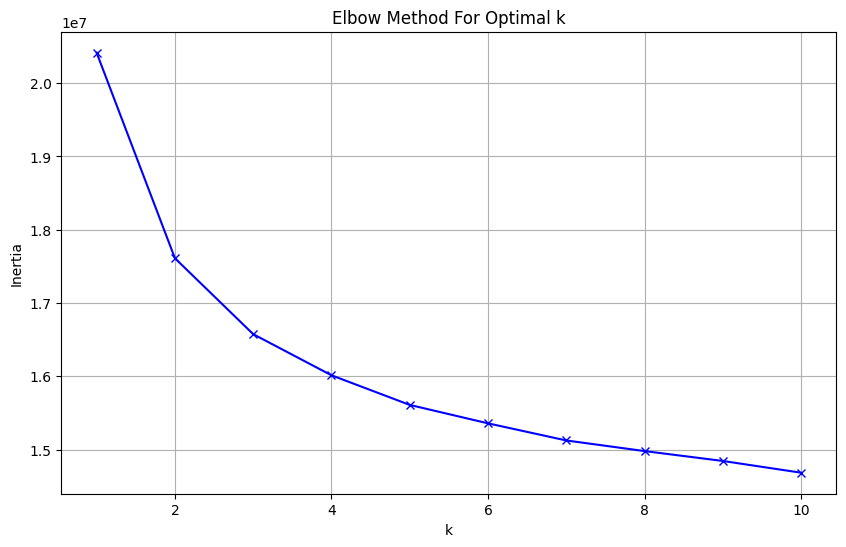

✅ KMeans clustering done with 4 clusters. Results saved to CSV.


/opt/anaconda3/envs/tech_club/lib/python3.12/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(
/opt/anaconda3/envs/tech_club/lib/python3.12/site-packages/factor_analyzer/utils.py:199: RuntimeWarning: divide by zero encountered in divide
  Is = np.sqrt(1 / np.diag(m))
/opt/anaconda3/envs/tech_club/lib/python3.12/site-packages/factor_analyzer/utils.py:200: RuntimeWarning: invalid value encountered in multiply
  retval = Is * m * np.repeat(Is, numrows).reshape(numrows, numrows)


🔎 KMO Model Score: nan


/opt/anaconda3/envs/tech_club/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/tech_club/lib/python3.12/site-packages/factor_analyzer/utils.py:90: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x, axis=0)) / np.std(x, axis=0, ddof=0)


ValueError: array must not contain infs or NaNs

In [ ]:
# Load dataset
file_path = '/Users/lucpellinger/Documents/Projects/BTC-Price-Prediction/Data/augmento_btc.csv'

dw = DataWrangler(file_path)

# Step 1: Summarize original dataset
dw.summarize_basic_dataset()

# Step 3: Optionally convert dates and extract datetime features
dw.convert_string_dates()
dw.extract_datetime_features()

# Step 4: Feature engineering (sentiment ratios)
platforms = ['reddit', 'twitter', 'bitcointalk']
#dw.engineer_relative_features(platforms)

# Step 5: Visualize the cleaned + transformed data
viz = DataVisualizer(dw.transformed)

# Define the visualizations you want to run:
viz.visualize([
    "log_standardize", 
    "elbow:max_k=10", 
    "kmeans:k=4", 
    "efa:variance_threshold=0.6,rotation=varimax", 
    "boxplot", 
    "cdf", 
    "kde", 
    "pearson_corr", 
    "spearman_corr"
])


This concludes the EDA for Twitter. Repeat similar steps for Reddit and Bitcointalk by modifying the prefix and reusing the modular `DataWrangler`.